<a href="https://colab.research.google.com/github/lfreese/female_geosci/blob/main/data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook to analyze Faculty in Geosciences Data

All data was taken from a spreadsheet created where we looked at 62 different Universities and their faculty makeup. We scrubbed names and split the data into two dataframes to improve anonymity of the data, and those two dataframes are available for use and reproduction of the work. Grad student data is from NSF data available at: 

# Import Dependencies and Set up Notebook with Drive

In [ ]:
#import dependencies
import pandas as pd #for those new to python, pandas will be what we use to make our 'dataframes' and is the easiest way to manipulate this data
import matplotlib.pyplot as plt #matplotlib is how we plot
import numpy as np
from scipy.stats import pearsonr
from scipy.interpolate import interp1d


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#when you run this cell, you will see a link pop up below. 
#Click on it and copy and paste the password it gives you into the box that appears below. 
#This authorizes the google drive to be used
#to check it works: you will have to click the 'files' option to the left, and the refresh files button--your drive will show up


Mounted at /content/drive


#Import Data

In [ ]:
uni_df = pd.read_csv('/content/drive/MyDrive/Diversity in Earth Sciences/Faculty Data/university_data.csv', index_col = 0)
disc_df = pd.read_csv('/content/drive/MyDrive/Diversity in Earth Sciences/Faculty Data/discipline_data.csv',index_col = 0)
grad_pd_df = pd.read_csv('/content/drive/MyDrive/Diversity in Earth Sciences/Faculty Data/grad_postdoc_data.csv')
grad_time_df = pd.read_csv('/content/drive/MyDrive/Diversity in Earth Sciences/Faculty Data/grad_time_data.csv', index_col = 1).drop('Unnamed: 0', axis=1)

# Data Modification

# Figure 1: Multi-decadal time-series of gender distribution in faculty by rank

In [ ]:
#calculate percent faculty
# add in other years of data (Wilson 1999, ...(fill out other citations))
other_data_dict = {'assistant professor':[22, 26, 27, 30, 32, 36],
                   'associate professor':[14, 15, 15, 18, 21, 24],
                   'professor':[5, 8, 8, 10, 11, 13]}
percent_faculty_df = uni_df.groupby(['Gender','Career Stage']).count().drop(columns = ['dept_head_gender','private_public'])
faculty_time_df = pd.DataFrame(index = ['assistant professor', 'associate professor', 'professor'], columns = [1999, 2002, 2008, 2010, 2013, 2015, 2020])
for lev in other_data_dict.keys():
  other_data_dict[lev].append((percent_faculty_df.loc['f']/(percent_faculty_df.loc['m']+percent_faculty_df.loc['f'])).loc[lev].values[0]*100)
  faculty_time_df.loc[lev] = other_data_dict[lev]
#faculty_time_df.loc['all'] = [12.5, 13, 17, 20, percent_faculty_df.loc['f'].sum()/(percent_faculty_df.sum())]
faculty_time_df = faculty_time_df.transpose()



In [ ]:
#calculate percent grad students
grad_time_df['percent_female'] = grad_time_df['Female']/(grad_time_df['Female'] + grad_time_df['Male'])*100

In [ ]:
# interpolate the percentages of women over the full range of years 1999-2021
f_assist = interp1d(faculty_time_df.index, faculty_time_df['assistant professor'])
f_assoc = interp1d(faculty_time_df.index, faculty_time_df['associate professor'])
f_prof = interp1d(faculty_time_df.index, faculty_time_df['professor'])
interp_dict = {'assistant professor':f_assist, 'associate professor':f_assoc,'professor':f_prof}
years = list(range(1999,2021))

faculty_interp_df = pd.DataFrame(index = years, columns = ['assistant professor interp', 'associate professor interp', 'professor interp'])
for lev in faculty_time_df.columns:
  faculty_interp_df[lev + ' interp'] = interp_dict[lev](years)

faculty_interp_df.index = faculty_interp_df.index.rename('Year')

#combine our faculty and grad student data
faculty_grad_df = pd.concat([faculty_interp_df, grad_time_df.sort_index(axis=0,ascending=False)], axis = 1)
faculty_grad_df.rename(columns = {'Male':'grad male', 'Female':'grad female','percent_female':'percent_grad_female'}, inplace = True)

In [ ]:
def fractionation(df, position_1, position_2, years_range, yrs_btw_position):
  '''fractionation factor calculation, where position 1 is the current position, position 2 is the past position, yrs btw position is the
  average years between the two, years range is the range of years of data to look at'''
  df[position_1 + ' frac ' + str(yrs_btw_position)] = np.nan
  for i in range(years_range):
    df[position_1 + ' frac ' + str(yrs_btw_position)].iloc[-i] = df[position_1].iloc[-i]/df[position_2].iloc[-i-yrs_btw_position]

In [ ]:
#calculate the fractionation factor for +/- 2 years around our average time
for yrs in range(5,10,1):
  fractionation(faculty_grad_df,'associate professor interp', 'assistant professor interp', 16, yrs)
  fractionation(faculty_grad_df,'professor interp', 'associate professor interp', 16, yrs)
for yrs in range(1,6,1):
  fractionation(faculty_grad_df,'assistant professor interp','percent_grad_female',20, yrs)

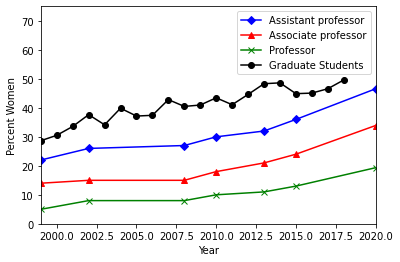

In [ ]:
marker = ['D','^','x']
color = ['b','r','g']
for idx, f in enumerate(faculty_time_df.columns):
  plt.plot(faculty_time_df[f], color = color[idx], marker = marker[idx], label = f.capitalize())
plt.plot(grad_time_df['percent_female'], 'ko-', label = 'Graduate Students')
plt.legend();
plt.xlim([1999, 2020])
plt.ylim([0, 75])
plt.xlabel('Year');
plt.ylabel('Percent Women');

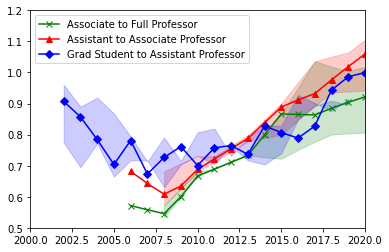

In [ ]:
plt.plot(faculty_grad_df['professor interp frac 7'],'gx-', label='Associate to Full Professor')
plt.fill_between(faculty_grad_df.index, faculty_grad_df['professor interp frac 9'],faculty_grad_df['professor interp frac 5'], color = 'g', alpha = 0.2)
plt.plot(faculty_grad_df['associate professor interp frac 7'],'r^-', label='Assistant to Associate Professor')
plt.fill_between(faculty_grad_df.index, faculty_grad_df['associate professor interp frac 9'],faculty_grad_df['associate professor interp frac 5'], color = 'r', alpha = 0.2)
plt.plot(faculty_grad_df['assistant professor interp frac 3'],'bD-', label='Grad Student to Assistant Professor')
plt.fill_between(faculty_grad_df.index, faculty_grad_df['assistant professor interp frac 1'],faculty_grad_df['assistant professor interp frac 5'], color = 'b', alpha = 0.2)
plt.legend()
plt.xlim([2000, 2020])
plt.ylim([0.5, 1.2]);

# Figure 2: Faculty gender distribution by sub-discipline

In [ ]:
subdisc_names = ['atmospheric chemistry','atmospheric dynamics',
         'geology','geophysics','geochemistry',
         'geobiology','chemical oceanography','biological oceanography',
         'physical oceanography','glaciology','hydrology','planetary science',
         'climate dynamics','sustainability','geomorphology','ecology','paleontology',
         'marine geology']



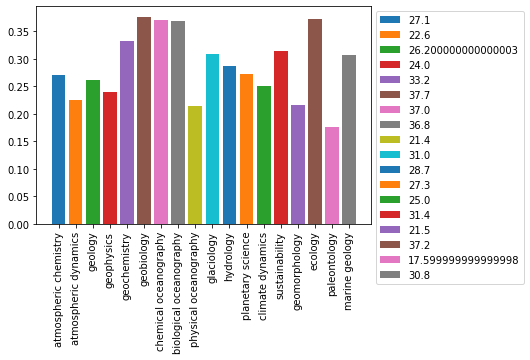

In [ ]:
for sd in subdisc_names:
  percent_f = (disc_df[disc_df['Discipline'].str.contains(sd, na=False)].loc[disc_df['Gender'] == 'f']['Discipline'].count()/
               disc_df[disc_df['Discipline'].str.contains(sd, na=False)]['Discipline'].count())
  plt.bar(sd, percent_f, label = np.round(percent_f,3)*100)
  plt.xticks(rotation = 90)
  plt.legend( bbox_to_anchor=(1, 1))


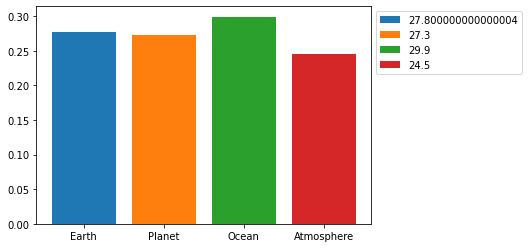

In [ ]:
for d in ['Earth','Planet','Ocean','Atmosphere']:
  percent_f = (disc_df[disc_df['EPAO'] == d].loc[disc_df['Gender'] == 'f']['Discipline'].count()/
               disc_df[disc_df['EPAO'] == d]['Discipline'].count())
  plt.bar(d, percent_f, label = np.round(percent_f,3)*100)
  plt.legend( bbox_to_anchor=(1, 1))

# Figure 3: Hiring Model - projected gender distribution over time and estimated percentage of women hired

## Model to compute percentage of women hired each year

In [ ]:
def percent_women_hired(yrs_2tenure, num_asst, yearly_hire, position):
  for yr in range(1999-yrs_2tenure,1999):
    #assume assistant prof % was same as in 1999 for previous years, with varying years for tenure
    faculty_grad_df[position +' interp'].loc[yr] = faculty_grad_df[position +' interp'][1999]
  faculty_grad_df[position +' num female ' + str(yrs_2tenure)] = faculty_grad_df[position +' interp']*num_asst/100
  faculty_grad_df[position +' num male '+ str(yrs_2tenure)] = (100-faculty_grad_df[position +' interp'])*num_asst/100
  faculty_grad_df[position +' delta female '+ str(yrs_2tenure)] = np.nan
  faculty_grad_df[position +' delta male '+ str(yrs_2tenure)] = np.nan
  for i in range(1999,2020):
    faculty_grad_df[position +' delta female '+ str(yrs_2tenure)].loc[i] = (faculty_grad_df[position +' num female '+ str(yrs_2tenure)].loc[i+1] - faculty_grad_df[position +' num female '+ str(yrs_2tenure)].loc[i])
    faculty_grad_df[position +' delta male '+ str(yrs_2tenure)].loc[i] = (faculty_grad_df[position +' num male '+ str(yrs_2tenure)].loc[i+1] - faculty_grad_df[position +' num male '+ str(yrs_2tenure)].loc[i])
  faculty_grad_df[position + ' num female hired '+ str(yrs_2tenure)] = 15.4
  faculty_grad_df[position + ' num male hired '+ str(yrs_2tenure)] = 54.6
  for i in range(1999,2020):
    faculty_grad_df[position + ' num female hired '+ str(yrs_2tenure)].loc[i] = faculty_grad_df[position +' delta female '+ str(yrs_2tenure)].loc[i]+faculty_grad_df[position +' num female '+ str(yrs_2tenure)].loc[i-yrs_2tenure]
    faculty_grad_df[position + ' num male hired '+ str(yrs_2tenure)].loc[i] = faculty_grad_df[position +' delta male '+ str(yrs_2tenure)].loc[i]+faculty_grad_df[position +' num male '+ str(yrs_2tenure)].loc[i-yrs_2tenure]
  faculty_grad_df[position + ' percent female hired '+ str(yrs_2tenure)] = faculty_grad_df[position + ' num female hired '+ str(yrs_2tenure)]/(faculty_grad_df[position + ' num female hired '+ str(yrs_2tenure)] + faculty_grad_df[position + ' num male hired '+ str(yrs_2tenure)])

In [ ]:
for i in range(7,10,1):
  percent_women_hired(i, 505, 70, 'assistant professor')

(0.0, 0.5)

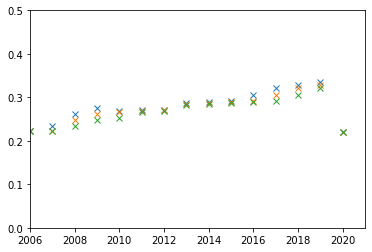

In [ ]:
for i in range(7,10,1):
  plt.plot(faculty_grad_df[f'assistant professor percent female hired {i}'],'x')
plt.xlim([2006, 2021])
plt.ylim([0, 0.5])

Old Code to draw from

In [ ]:
def percent_women_hired(num_asst_prof, yearly_hire, ):
  
  years_sparse = [1999, 2002, 2008, 2010, 2013, 2015, 2020];
  years = list(range(1999,2021))
  f1 = interp1d(years_sparse,percent_female_asstprof); #interpolation function
  percent_asst_interp = f1(years) 
  for i in range(8):#8
  percent_asst_interp = np.insert(percent_asst_interp,0,22)

  num_asst = 505
  yearly_hire = 70

  num_women = percent_asst_interp*num_asst/100
  num_men = (100-percent_asst_interp)*num_asst/100

  delta_women = []
  delta_men = []
  for i in range(len(num_women)-1):
    delta_women.append(num_women[i+1]-num_women[i])
    delta_men.append(num_men[i+1]-num_men[i])
  delta_women.insert(0,0)
  delta_men.insert(0,0)

  num_women_hired = [0]*len(delta_women)
  num_men_hired = [0]*len(delta_men)
  for i in range(9):#9
    num_women_hired[i] = 15.4
    num_men_hired[i] = 54.6

  num_women_hired = np.array(num_women_hired)
  num_men_hired = np.array(num_men_hired)
  for i in range(9,30):#9,20
    num_women_hired[i] = delta_women[i]+num_women_hired[i-8]#8
    num_men_hired[i] = delta_men[i]+num_men_hired[i-8]#8

  percent_women_hired_8 = num_women_hired/(num_women_hired+num_men_hired)


In [ ]:
years_sparse = [1999, 2002, 2008, 2010, 2013, 2015, 2020];
years = list(range(1999,2021))
f1 = interp1d(years_sparse,percent_female_asstprof); #interpolation function
percent_asst_interp = f1(years) 

for i in range(8):#8
  percent_asst_interp = np.insert(percent_asst_interp,0,22)

In [ ]:
# Compute percentage of women hired, assuming time to tenure is 8 years


years_sparse = [1999, 2002, 2008, 2010, 2013, 2015, 2020];
years = list(range(1999,2021))
f1 = interp1d(years_sparse,percent_female_asstprof);
percent_asst_interp = f1(years) 

for i in range(8):#8
  percent_asst_interp = np.insert(percent_asst_interp,0,22)

num_asst = 505
yearly_hire = 70

num_women = percent_asst_interp*num_asst/100
num_men = (100-percent_asst_interp)*num_asst/100

delta_women = []
delta_men = []
for i in range(len(num_women)-1):
  delta_women.append(num_women[i+1]-num_women[i])
  delta_men.append(num_men[i+1]-num_men[i])
delta_women.insert(0,0)
delta_men.insert(0,0)

num_women_hired = [0]*len(delta_women)
num_men_hired = [0]*len(delta_men)
for i in range(9):#9
  num_women_hired[i] = 15.4
  num_men_hired[i] = 54.6

num_women_hired = np.array(num_women_hired)
num_men_hired = np.array(num_men_hired)
for i in range(9,30):#9,20
  num_women_hired[i] = delta_women[i]+num_women_hired[i-8]#8
  num_men_hired[i] = delta_men[i]+num_men_hired[i-8]#8

percent_women_hired_8 = num_women_hired/(num_women_hired+num_men_hired)

# find the percent of hires that are women assuming the time to tenure is 9 years

years_sparse = [1999, 2002, 2008, 2010, 2013, 2015, 2020];
years = list(range(1999,2021))
f1 = interp1d(years_sparse,percent_female_asstprof);
percent_asst_interp = f1(years) 

for i in range(9):#8
  percent_asst_interp = np.insert(percent_asst_interp,0,22)

num_asst = 505
yearly_hire = 70

num_women = percent_asst_interp*num_asst/100
num_men = (100-percent_asst_interp)*num_asst/100

delta_women = []
delta_men = []
for i in range(len(num_women)-1):
  delta_women.append(num_women[i+1]-num_women[i])
  delta_men.append(num_men[i+1]-num_men[i])
delta_women.insert(0,0)
delta_men.insert(0,0)

num_women_hired = [0]*len(delta_women)
num_men_hired = [0]*len(delta_men)
for i in range(10):#9
  num_women_hired[i] = 15.4
  num_men_hired[i] = 54.6

num_women_hired = np.array(num_women_hired)
num_men_hired = np.array(num_men_hired)
for i in range(10,31):#9,20
  num_women_hired[i] = delta_women[i]+num_women_hired[i-9]#8
  num_men_hired[i] = delta_men[i]+num_men_hired[i-9]#8

percent_women_hired_9 = num_women_hired/(num_women_hired+num_men_hired)


In [ ]:
# Compute percentage of women hired, assuming time to tenure is 8 years

from scipy.interpolate import interp1d

years_sparse = [1999, 2002, 2008, 2010, 2013, 2015, 2020];
years = list(range(1999,2021))
f1 = interp1d(years_sparse,percent_female_asstprof);
percent_asst_interp = f1(years) 

for i in range(7):
  percent_asst_interp = np.insert(percent_asst_interp,0,22)

num_asst = 505
yearly_hire = 70

num_women = percent_asst_interp*num_asst/100
num_men = (100-percent_asst_interp)*num_asst/100

delta_women = []
delta_men = []
for i in range(len(num_women)-1):
  delta_women.append(num_women[i+1]-num_women[i])
  delta_men.append(num_men[i+1]-num_men[i])
delta_women.insert(0,0)
delta_men.insert(0,0)

num_women_hired = [0]*len(delta_women)
num_men_hired = [0]*len(delta_men)
for i in range(8):
  num_women_hired[i] = 15.4
  num_men_hired[i] = 54.6

num_women_hired = np.array(num_women_hired)
num_men_hired = np.array(num_men_hired)
for i in range(8,29):
  num_women_hired[i] = delta_women[i]+num_women_hired[i-7]
  num_men_hired[i] = delta_men[i]+num_men_hired[i-7]

percent_women_hired_7 = num_women_hired/(num_women_hired+num_men_hired)


In [ ]:
# Compute percentage of women hired, assuming time to tenure is 6 years

from scipy.interpolate import interp1d

years_sparse = [1999, 2002, 2008, 2010, 2013, 2015, 2020];
years = list(range(1999,2021))
f1 = interp1d(years_sparse,percent_female_asstprof);
percent_asst_interp = f1(years) 

for i in range(6):#6
  percent_asst_interp = np.insert(percent_asst_interp,0,22)

num_asst = 505
yearly_hire = 70

num_women = percent_asst_interp*num_asst/100
num_men = (100-percent_asst_interp)*num_asst/100

delta_women = []
delta_men = []
for i in range(len(num_women)-1):
  delta_women.append(num_women[i+1]-num_women[i])
  delta_men.append(num_men[i+1]-num_men[i])
delta_women.insert(0,0)
delta_men.insert(0,0)

num_women_hired = [0]*len(delta_women)
num_men_hired = [0]*len(delta_men)
for i in range(7):#7
  num_women_hired[i] = 15.4
  num_men_hired[i] = 54.6

num_women_hired = np.array(num_women_hired)
num_men_hired = np.array(num_men_hired)
for i in range(7,28):#7,28
  num_women_hired[i] = delta_women[i]+num_women_hired[i-6]#6
  num_men_hired[i] = delta_men[i]+num_men_hired[i-6]#6

percent_women_hired_6 = num_women_hired/(num_women_hired+num_men_hired)

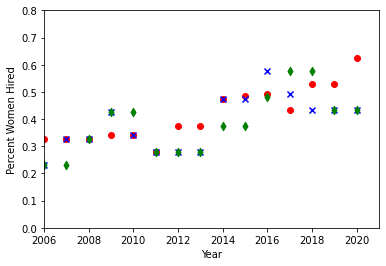

In [ ]:
plt.scatter(years,percent_women_hired_6[6:len(percent_women_hired_6)],marker='o',color='r')
plt.scatter(years,percent_women_hired_7[7:len(percent_women_hired_7)],marker='x',color='b')
plt.scatter(years,(percent_women_hired_8[8:len(percent_women_hired_8)]),marker='d',color='g')
#plt.grid()
plt.xlim([2006, 2021])
plt.ylim([0, 0.8])
plt.xlabel('Year');
plt.ylabel('Percent Women Hired');
plt.savefig('percent_women_hired.png')

## Model to project time to gender parity

In [ ]:
# Hiring model to determine time to gender parity
import numpy as np

num_years = 50 # how many years out to predict
years = list(range(0,num_years)) 

# size of pools
full_pool = 1471
associate_pool = 466
assistant_pool = 505

full_frac_women = 284/full_pool # 284 women
associate_frac_women = 158/associate_pool # 158 women
assistant_frac_women = 236/assistant_pool # 236 women

# we assume steady state in the faculty pool and career length is 35 years
careerlength = 35
promotion1 = 7 # years from hire to associate professor
promotion2 = 7 # years from associate to full professor
retire = careerlength - promotion1 - promotion2 # number of years between being a full professor and retirement

# assume even distribution across faculty ranks + choose flux; consider deleting if not necessary
x = full_pool/retire
y = associate_pool/promotion2
z = assistant_pool/promotion1
flux_high = 70
flux_low = 70
# seems like a flux between 60-70 people per year is reasonable

# set up arrays for the fraction of women in each year if we start hiring at 50/50 now
full_prof_bestcase_1 = 0.5*np.ones((num_years-retire-promotion1-promotion2)) # if we hire at 50/50 now, the full professors at some point will have a fraction of women = 0.5
full_prof_bestcase_2 = assistant_frac_women*np.ones(promotion1) # the upcoming associate professors have a fraction of women = fraction of women at assistant professor stage assuming no attrition
full_prof_bestcase_3 = associate_frac_women*np.ones(promotion2) # the upcoming professors have a fraction of women = fraction of women at associate professor stage assuming no attrition
full_prof_bestcase_4 = full_frac_women*np.ones(retire) # the upcoming retired professors have a fraction of women = fraction of women at professor stage
full_prof_bestcase = np.concatenate((full_prof_bestcase_1,full_prof_bestcase_2,full_prof_bestcase_3,full_prof_bestcase_4),axis=0)

assoc_prof_bestcase_1 = 0.5*np.ones(num_years-promotion1-promotion2) 
assoc_prof_bestcase_2 = assistant_frac_women*np.ones(promotion1)
assoc_prof_bestcase_3 = associate_frac_women*np.ones(promotion2)
assoc_prof_bestcase = np.concatenate((assoc_prof_bestcase_1,assoc_prof_bestcase_2,assoc_prof_bestcase_3),axis=0)

asst_prof_bestcase_1 = 0.5*np.ones(num_years-promotion1)
asst_prof_bestcase_2 = assistant_frac_women*np.ones(promotion1)
asst_prof_bestcase = np.concatenate((asst_prof_bestcase_1,asst_prof_bestcase_2),axis=0)

# set up arrays for the fraction of women in each year if we continue hiring as we are now
full_prof_current_1 = assistant_frac_women*np.ones(num_years-retire-promotion1-promotion2)
full_prof_current_2 = assistant_frac_women*np.ones(promotion1)
full_prof_current_3 = associate_frac_women*np.ones(promotion2)
full_prof_current_4 = full_frac_women*np.ones(retire)
full_prof_current = np.concatenate((full_prof_current_1,full_prof_current_2,full_prof_current_3,full_prof_current_4),axis=0)

assoc_prof_current_1 = assistant_frac_women*np.ones(num_years-promotion1-promotion2)
assoc_prof_current_2 = assistant_frac_women*np.ones(promotion1)
assoc_prof_current_3 = associate_frac_women*np.ones(promotion2)
assoc_prof_current = np.concatenate((assoc_prof_current_1,assoc_prof_current_2,assoc_prof_current_3),axis=0)

asst_prof_current_1 = assistant_frac_women*np.ones(num_years-promotion1)
asst_prof_current_2 = assistant_frac_women*np.ones(promotion1)
asst_prof_current = np.concatenate((asst_prof_current_1,asst_prof_current_2),axis=0)

# create the lists of numbers of women at each rank for each year considered
numwomen_full_bestcase = np.ones(num_years)
numwomen_assoc_bestcase = np.ones(num_years)
numwomen_asst_bestcase = np.ones(num_years)
numwomen_full_current = np.ones(num_years)
numwomen_assoc_current = np.ones(num_years)
numwomen_asst_current = np.ones(num_years)

# initialize the lists with the current distribution
numwomen_full_bestcase[0] = 284
numwomen_assoc_bestcase[0] = 158
numwomen_asst_bestcase[0] = 236
numwomen_full_current[0] = 284
numwomen_assoc_current[0] = 158
numwomen_asst_current[0] = 236

x = num_years
for i in range(1,num_years):
  x = x-1
  numwomen_full_bestcase[i] = numwomen_full_bestcase[i-1]-flux_high*full_prof_bestcase[x]+assoc_prof_bestcase[x]*flux_high
  numwomen_assoc_bestcase[i] = numwomen_assoc_bestcase[i-1]-flux_high*assoc_prof_bestcase[x]+asst_prof_bestcase[x]*flux_high
  numwomen_asst_bestcase[i] = numwomen_asst_bestcase[i-1]-flux_high*asst_prof_bestcase[x]+0.5*flux_high

  numwomen_full_current[i] = numwomen_full_current[i-1]-flux_low*full_prof_current[x]+assoc_prof_current[x]*flux_low
  numwomen_assoc_current[i] = numwomen_assoc_current[i-1]-flux_low*assoc_prof_current[x]+asst_prof_current[x]*flux_low
  numwomen_asst_current[i] = numwomen_asst_current[i-1]-flux_low*asst_prof_current[x]+assistant_frac_women*flux_low

projected_total_bestcase = (numwomen_full_bestcase+numwomen_assoc_bestcase+numwomen_asst_bestcase)/(full_pool+associate_pool+assistant_pool)
projected_total_current = (numwomen_full_current+numwomen_assoc_current+numwomen_asst_current)/(full_pool+associate_pool+assistant_pool)
projected_full_bestcase = numwomen_full_bestcase/full_pool
projected_full_current = numwomen_full_current/full_pool
projected_assoc_bestcase = numwomen_assoc_bestcase/associate_pool
projected_assoc_current = numwomen_assoc_current/associate_pool
projected_asst_bestcase = numwomen_asst_bestcase/assistant_pool
projected_asst_current = numwomen_asst_current/assistant_pool


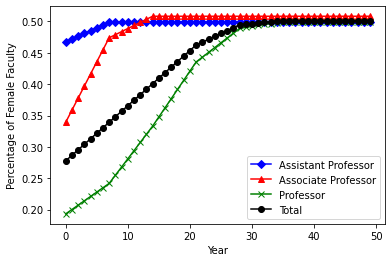

In [ ]:
# plot time to gender parity

plt.plot(years, projected_asst_bestcase,'bD-', label='Assistant Professor')
plt.plot(years, projected_assoc_bestcase,'r^-', label='Associate Professor')
plt.plot(years, projected_full_bestcase,'gx-', label = 'Professor')
plt.plot(years, projected_total_bestcase,'ko-', label = 'Total')
plt.legend();
#plt.grid()
plt.xlabel('Year');
plt.ylabel('Percentage of Female Faculty');